In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import cv2
import os
import json
import numpy as np
import matplotlib.pyplot as plt

from concurrent import futures

In [7]:
from src import image_metrics, io_utils, image_utils
from src.Tile import Tile

# Filtering by multitile-ness

I am going to assume that individual tile is contrasting and symmetric. In this notebook I will attempt to select images that consist of multiple different tiles.

As before, I am going to work on cropped images.

In [17]:
folder_list = [
    'dataset/google/azulejo',
#     'dataset/google/portuguese tiles',
#     'dataset/bing/azulejo',
#     'dataset/bing/portuguese tile',
#     'dataset/bing/azulejo vector',
    'dataset/bing/portuguese tile vector'
]

In [18]:
from skimage.metrics import structural_similarity as ssim, normalized_root_mse

def similarity_mse_based(x, y): return 1 - normalized_root_mse(x, y)
def similarity_ssim_based(x, y): return ssim(x, y, multichannel=True)

metrics = [similarity_mse_based, similarity_ssim_based]

In [19]:
new_size=(64, 64)

def prepare_image(img): return image_utils.prepare(
    img, 
    resize=False, 
    apply_contrast=True, 
    apply_blur=False
)

def _prepare_image_subtile(img): return image_utils.resize(img, new_size)

def tile_multitileness(tile, pieces, metric, agg, similarity_check_sample=100, **kwargs):
    tile_list = tile.get_pieces(pieces)
    symmetries = [None] * pieces**2
    
    for i, tile_piece in enumerate(tile_list):
        img = _prepare_image_subtile(tile_piece.img)
        img_center = _prepare_image_subtile(tile_piece.get_square_from_center(0.33).img)
        
        symmetry = image_metrics.tile_symmetry(Tile(img), metric, agg, **kwargs)
        symmetry_center = image_metrics.tile_symmetry(Tile(img_center), metric, agg, **kwargs)
        
        symmetries[i] = agg(symmetry, symmetry_center)
    
    similarities = [None] * similarity_check_sample
    for i in range(similarity_check_sample):
        j, k = np.random.choice(range(pieces), 2, replace=False)
        img_j = _prepare_image_subtile(tile_list[j].img)
        img_k = _prepare_image_subtile(tile_list[k].img)
        similarities[i] = metric(img_j, img_k, **kwargs)
    
    return {'symmetry': symmetries, 'similarity': similarities}

In [20]:
# for folder in folder_list:
#     print('Working on {} folder.'.format(folder))
#     files = [_.strip() for _ in open('lists/contrasting_{}.txt'.format(folder.replace('/', '-')), 'r').readlines()]
    
#     imgs = [
#         img 
#         for img 
#         in io_utils.read_imgs(files, folder)
#     ]
#     tiles = [Tile(prepare_image(img)) for img in imgs]
    
#     for n in [2, 3, 4]:
#         print('Checking for {n}x{n} tiles.'.format(n=n))
#         with futures.ThreadPoolExecutor(max_workers=15) as executor:
#             multitileness_ssim = {
#                 file: executor.submit(tile_multitileness, tile, n, similarity_ssim_based, min)
#                 for (file, tile) in zip(files, tiles)
#             }
#         with open('temp/{folder}_{n}x{n}_ssim.json'.format(folder=folder.replace('/', '-'), n=n), 'w') as file: 
#             json.dump({k: v.result() for k, v in multitileness_ssim.items()}, file)
    
#         with futures.ThreadPoolExecutor(max_workers=15) as executor:
#             multitileness_mse = {
#                 file: executor.submit(tile_multitileness, tile, n, similarity_mse_based, min)
#                 for (file, tile) in zip(files, tiles)
#             }
#         with open('temp/{folder}_{n}x{n}_mse.json'.format(folder=folder.replace('/', '-'), n=n), 'w') as file: 
#             json.dump({k: v.result() for k, v in multitileness_mse.items()}, file)
        
#     print('\n\n')

Working on dataset/google/azulejo folder.
Checking for 2x2 tiles.
Symmetries of the images' cut into 2x2 parts


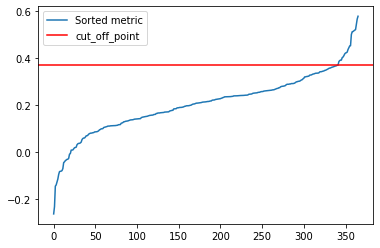

Random sample of probably not 2x2 tiles:


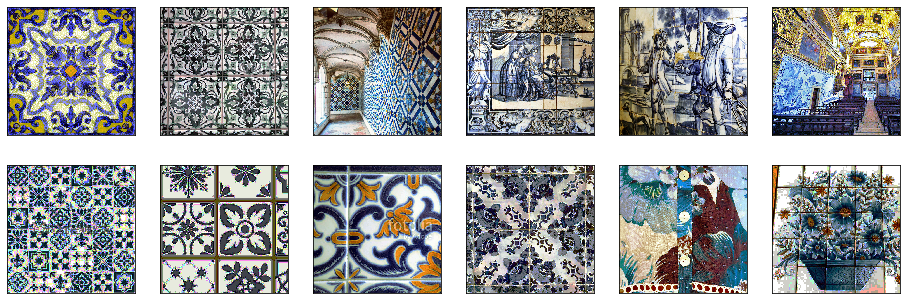

Random sample of 2x2 tiles:


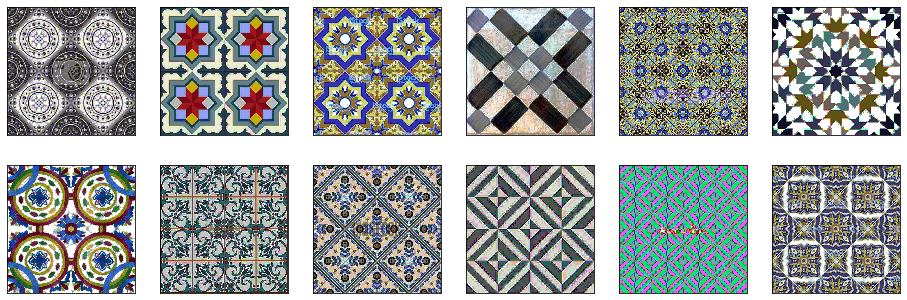

2x2 tile files: 26.



Checking for 3x3 tiles.
Symmetries of the images' cut into 3x3 parts


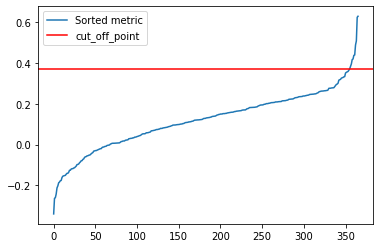

Random sample of probably not 3x3 tiles:


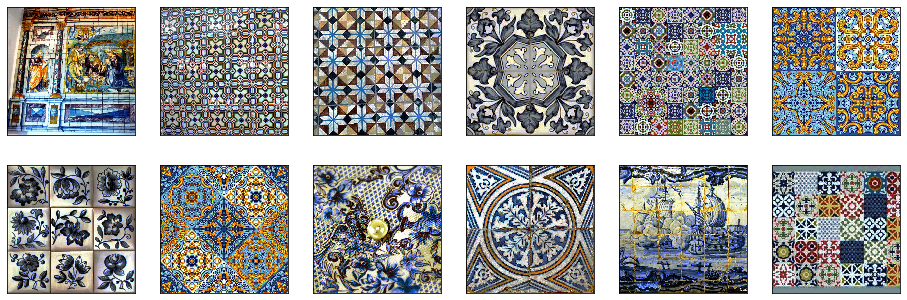

Random sample of 3x3 tiles:


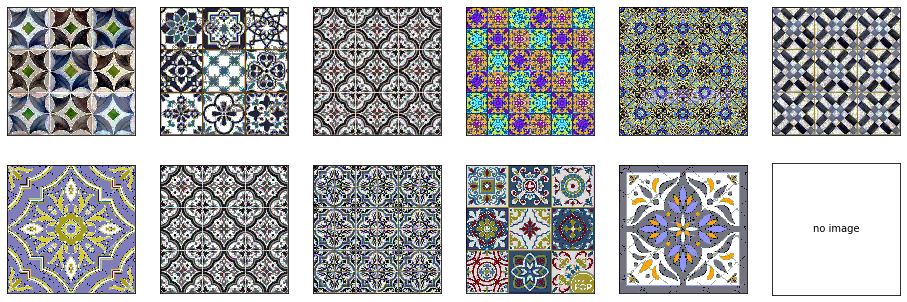

3x3 tile files: 11.



Checking for 4x4 tiles.
Symmetries of the images' cut into 4x4 parts


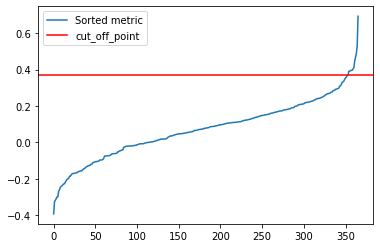

Random sample of probably not 4x4 tiles:


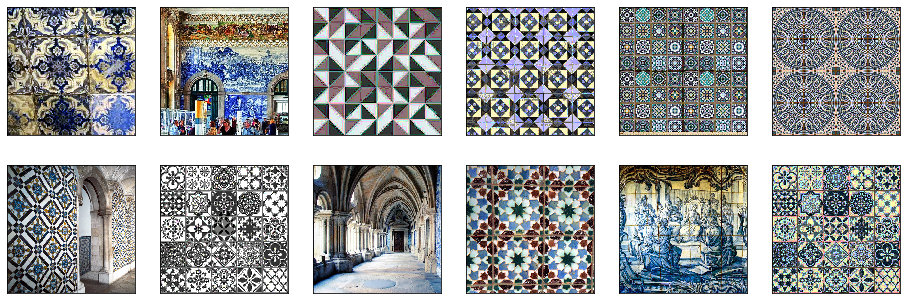

Random sample of 4x4 tiles:


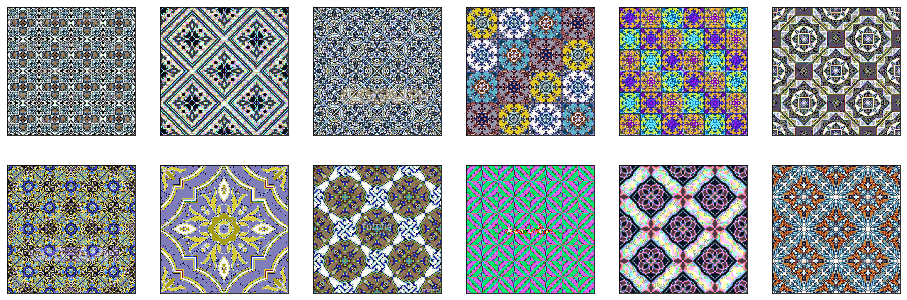

4x4 tile files: 12.



Working on dataset/bing/portuguese tile vector folder.
Checking for 2x2 tiles.
Symmetries of the images' cut into 2x2 parts


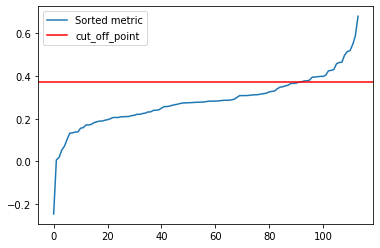

Random sample of probably not 2x2 tiles:


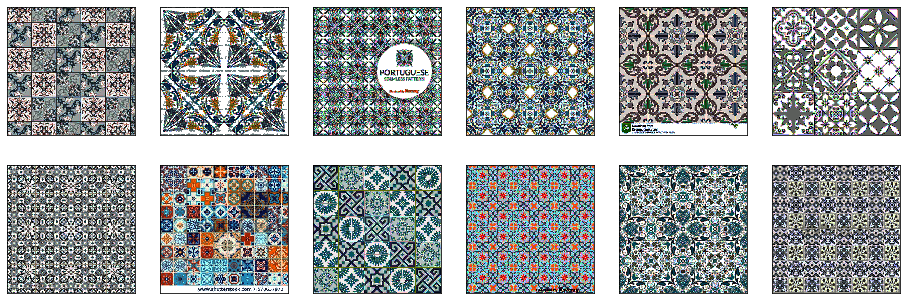

Random sample of 2x2 tiles:


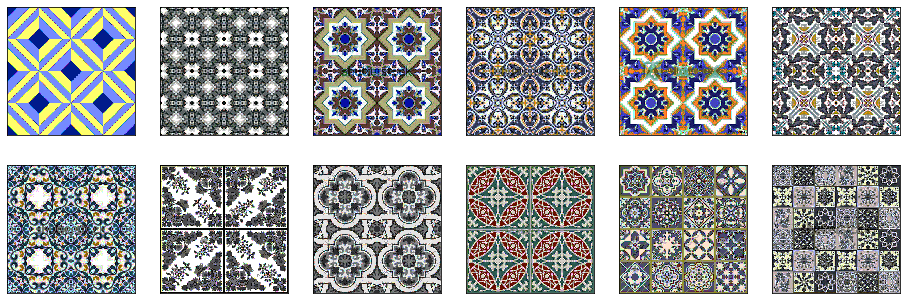

2x2 tile files: 23.



Checking for 3x3 tiles.
Symmetries of the images' cut into 3x3 parts


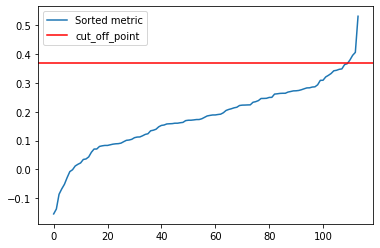

Random sample of probably not 3x3 tiles:


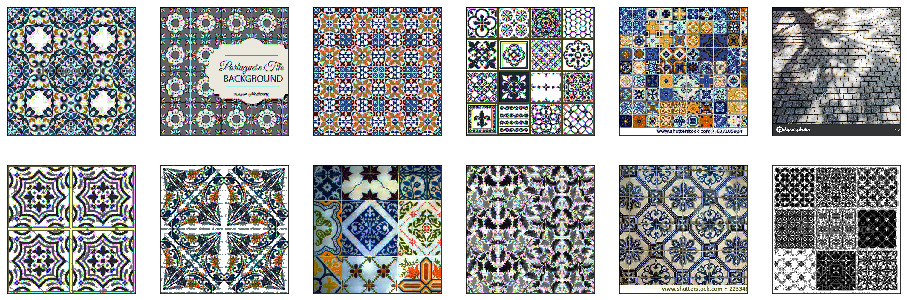

Random sample of 3x3 tiles:


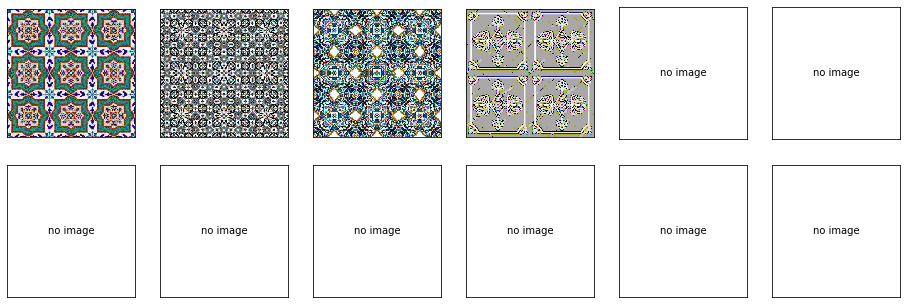

3x3 tile files: 4.



Checking for 4x4 tiles.
Symmetries of the images' cut into 4x4 parts


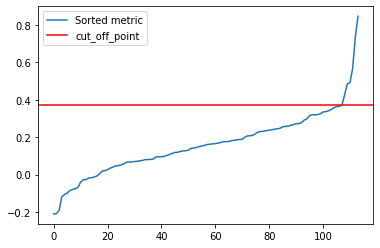

Random sample of probably not 4x4 tiles:


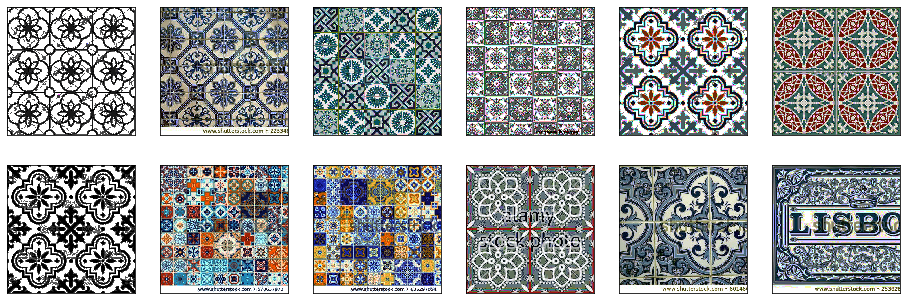

Random sample of 4x4 tiles:


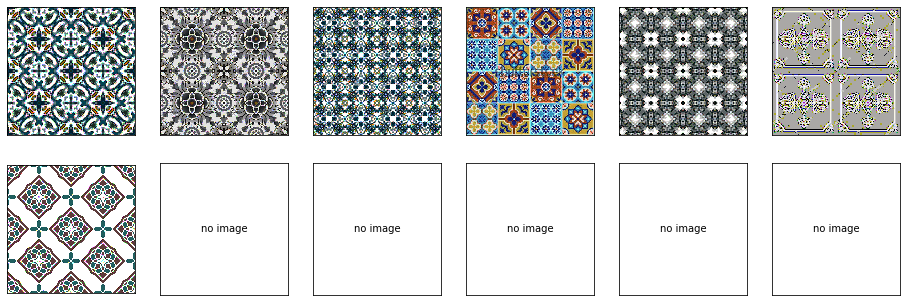

4x4 tile files: 7.





In [21]:
plot_sample = 12
cut_offs = {2:0.37, 3:0.37, 4:0.37}

for folder in folder_list:
    print('Working on {} folder.'.format(folder))
    
    files = [_.strip() for _ in open('lists/contrasting_{}.txt'.format(folder.replace('/', '-')), 'r').readlines()]
    
    img_dict = {
        file: prepare_image(img)
        for file, img
        in zip(files, io_utils.read_imgs(files, folder))
    }

    for n in [2, 3, 4]:
        print('Checking for {n}x{n} tiles.'.format(n=n))
        
        img_dict_n = {k: v for k, v in img_dict.items() if min(v.shape[0], v.shape[1]) >= new_size[0]*n / 2}
        
        with open('temp/{folder}_{n}x{n}_mse.json'.format(folder=folder.replace('/', '-'), n=n), 'r') as file:
            metrics = json.load(file)
        
        metrics_multi = {
            k: np.min(v['symmetry'])
            for k, v 
            in metrics.items()
            if (k in img_dict_n) #and (np.mean(v['symmetry']) >= np.mean(v['similarity']))
        }
              
        print('Symmetries of the images\' cut into {n}x{n} parts'.format(n=n))
        io_utils.plot_metric(metrics_multi.values(), cut_offs[n])
        
        files_multi = [
            file 
            for (file, symmetry) 
            in metrics_multi.items() 
            if (symmetry > cut_offs[n])
        ]
        
        imgs_multi = [img_dict[file] for file in files_multi]
        
        files_other = [
            _ 
            for _ 
            in metrics_multi.keys() 
            if (_ not in files_multi)
        ]
        
        imgs_other = [img_dict[file] for file in files_other if file in img_dict_n]
    
        print('Random sample of probably not {n}x{n} tiles:'.format(n=n))
        io_utils.plot_sample_imgs(imgs_other, plot_sample=plot_sample)

        print('Random sample of {n}x{n} tiles:'.format(n=n))
        io_utils.plot_sample_imgs(imgs_multi, plot_sample=plot_sample)

        print('{n}x{n} tile files: {k}.'.format(n=n, k=len(files_multi)))
        
        with open(
            'lists/multitile_{n}x{n}_{folder}.txt'.format(n=n, folder=folder.replace('/', '-')), 'w'
        ) as filehandle:
            for filename in files_multi:
                filehandle.write('%s\n' % filename)
        
        print('\n\n')